In [1]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
from src.constants import PATH_FINAL, PATH_DATABASE, PATH_MAX_GAN

In [2]:
con = duckdb.connect(":memory:", read_only=False)

In [3]:
con.sql(
    f"""
    CREATE OR REPLACE TABLE ganancia_maxima AS (
        SELECT
            *
        FROM read_parquet('{PATH_FINAL}')
    )
    """
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [4]:
con.sql(
    """
    SELECT
        *
    FROM ganancia_maxima
    LIMIT 10
    """
)

┌───────────────────┬──────────┬────────────────┬───┬──────────────────────┬──────────────────────┐
│ numero_de_cliente │ foto_mes │ active_quarter │ … │ clase_ternaria_202…  │ clase_ternaria_202…  │
│       int64       │  int64   │     int64      │   │       varchar        │       varchar        │
├───────────────────┼──────────┼────────────────┼───┼──────────────────────┼──────────────────────┤
│          87372554 │   202106 │              1 │ … │ CONTINUA             │ CONTINUA             │
│          87372956 │   202106 │              1 │ … │ CONTINUA             │ CONTINUA             │
│          87377576 │   202106 │              1 │ … │ CONTINUA             │ CONTINUA             │
│          87377857 │   202106 │              1 │ … │ CONTINUA             │ CONTINUA             │
│          87381598 │   202106 │              0 │ … │ CONTINUA             │ CONTINUA             │
│          87383391 │   202106 │              1 │ … │ CONTINUA             │ CONTINUA             │


In [5]:
con.sql(
    """
    CREATE OR REPLACE TABLE ganancia_maxima AS (
        SELECT
            *,
            CASE 
                WHEN clase_ternaria_202109 = 'BAJA+2' THEN 270000
                ELSE 0
            END AS weights
        FROM ganancia_maxima
    )
    """
)

In [6]:
con.sql(
    """
    SELECT
        *
    FROM ganancia_maxima
    LIMIT 10
    """
)

┌───────────────────┬──────────┬────────────────┬───┬──────────────────────┬──────────────────────┬─────────┐
│ numero_de_cliente │ foto_mes │ active_quarter │ … │ clase_ternaria_202…  │ clase_ternaria_202…  │ weights │
│       int64       │  int64   │     int64      │   │       varchar        │       varchar        │  int32  │
├───────────────────┼──────────┼────────────────┼───┼──────────────────────┼──────────────────────┼─────────┤
│          87372554 │   202106 │              1 │ … │ CONTINUA             │ CONTINUA             │       0 │
│          87372956 │   202106 │              1 │ … │ CONTINUA             │ CONTINUA             │       0 │
│          87377576 │   202106 │              1 │ … │ CONTINUA             │ CONTINUA             │       0 │
│          87377857 │   202106 │              1 │ … │ CONTINUA             │ CONTINUA             │       0 │
│          87381598 │   202106 │              0 │ … │ CONTINUA             │ CONTINUA             │       0 │
│         

In [7]:
con.sql(
    """
    CREATE OR REPLACE TABLE ganancia_maxima AS (
    SELECT
        foto_mes,
        (SUBSTR(foto_mes, 1, 4) || '-' || SUBSTR(foto_mes, 5, 2) || '-01')::DATE AS foto_mes_date,
        SUM(weights) AS ganancia_max
    FROM ganancia_maxima
    GROUP BY
        foto_mes
    )
    """
)

In [8]:
con.sql(
    """
    UPDATE ganancia_maxima
    SET ganancia_max = NULL
    WHERE foto_mes >= 202108
    """
)

In [9]:
df = con.sql(
    """
    SELECT * FROM ganancia_maxima
    """
).to_df()

In [10]:
df.head()

,foto_mes,foto_mes_date,ganancia_max
0,202007,2020-07-01,144450000.0
1,202008,2020-08-01,125550000.0
2,202009,2020-09-01,148770000.0
3,202010,2020-10-01,140940000.0
4,202011,2020-11-01,163890000.0


In [11]:
df["foto_mes_date"].unique()

<DatetimeArray>
['2020-07-01 00:00:00', '2020-08-01 00:00:00', '2020-09-01 00:00:00',
 '2020-10-01 00:00:00', '2020-11-01 00:00:00', '2020-12-01 00:00:00',
 '2021-01-01 00:00:00', '2021-02-01 00:00:00', '2021-03-01 00:00:00',
 '2021-04-01 00:00:00', '2021-05-01 00:00:00', '2021-06-01 00:00:00',
 '2021-07-01 00:00:00', '2021-08-01 00:00:00', '2021-09-01 00:00:00']
Length: 15, dtype: datetime64[ns]

In [12]:
df.isnull().sum()

foto_mes         0
foto_mes_date    0
ganancia_max     2
dtype: int64

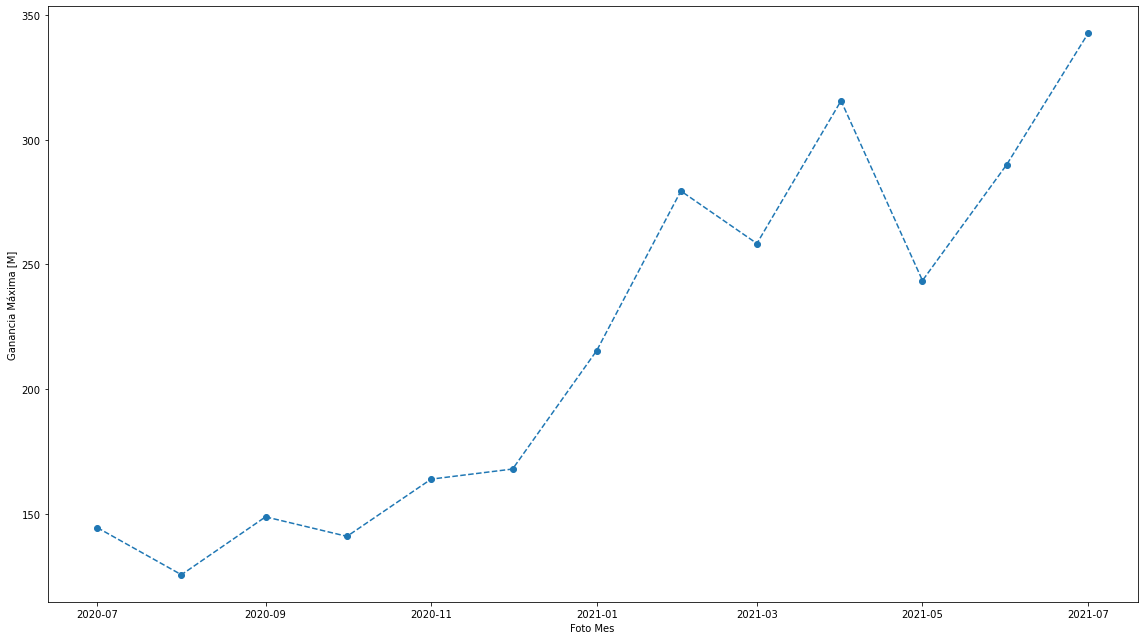

In [13]:
plt.figure(figsize=(16,9))
plt.plot(df["foto_mes_date"].values,df["ganancia_max"].values/1000000, 'o--')
plt.xlabel("Foto Mes")
plt.ylabel("Ganancia Máxima [M]")
plt.tight_layout()
plt.show()

In [14]:
df.to_parquet(PATH_MAX_GAN)